In [1]:
import metpy.calc as mpcalc
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
import matplotlib as mpl
import numpy.ma as ma
import pyart
import metpy 
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.

%matplotlib inline

# A couple plot parameter changes... May add more, creates less work later
plt.rcParams.update({"font.size":30})
mpl.rcParams['legend.fontsize'] = 'large'

In [ ]:
from pathlib import Path

HRRR= Path("/export/home/mbrewer/HRRR/hrrr.t18z.wrfprsf00_1108.nc")

el = Path("/export/home/mbrewer/Documents/GMTED2010_15n030_0125deg.nc")

rad = Path("/export/home/mbrewer/Documents/radar_files/KBBX20181108_175909_V06")


In [3]:
ds = xr.open_dataset(HRRR)
elev = xr.open_dataset(el)

data = ds.metpy.parse_cf()

### Here I am indexing my data to find the nearest grid point to Paradise Ca

In [4]:
# The Lat/lon of paradise
wp_lat =  39.697254
wp_lon = -121.574221
#HRRR lat/lon points
lat = data.gridlat_0
lon = data.gridlon_0
#Subtracting the station lat/lon from all the lat/lon points, them from there finding the minimum difference which gives the closest grid box index
abslat = np.abs(lat-wp_lat)
abslon= np.abs(lon-wp_lon)
c = np.maximum(abslon,abslat)
xx, yy = np.where(c == np.min(c))
print(xx,yy) 

[663] [220]


In [32]:
### Here I am abritrarily indexing my data so when I plot the data it doesnt take forever. The area I picked is likely too big but it speeds some of plots up by ~5mins
uwind_pres = ds.UGRD_P0_L100_GLC0[:,0:int(yy+1000),0:int(xx+500)] 
vwind_pres =ds.VGRD_P0_L100_GLC0[:,0:int(yy+1000),0:int(xx+500)]
uwind_10m = ds.UGRD_P0_L103_GLC0[0,0:int(yy+1000),0:int(xx+500)]
vwind_10m = ds.VGRD_P0_L103_GLC0[0,0:int(yy+1000),0:int(xx+500)]
RH_2m =ds.RH_P0_L103_GLC0[0:int(yy+1000),0:int(xx+500)]
DPT_K = ds.DPT_P0_L103_GLC0[0:int(yy+1000),0:int(xx+500)]

#Parsing a seperate RH variable using metpy functionality which gives these nice x,y lat/lon variables.... Mostly doing this bc I am lazy when I code and typing x/y is quick
RH = data.metpy.parse_cf('RH_P0_L100_GLC0')
RH = RH[:,0:int(yy+1000),0:int(xx+500)]
x, y = RH.metpy.coordinates('x', 'y')
#lon_2d, lat_2d = np.meshgrid(ds['gridlon_0'], ds['gridlat_0'])

In [6]:
# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([-108+360.,-126.5+360., 32., 49.])
    ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
    #gl = ax.gridlines(draw_labels=True)
    #gl.xlabels_top = gl.ylabels_right = False
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

In [7]:
#Creaing a projection object based of the  HRRR projection
lccProjParams_HRRR = { 'central_latitude'   : -38.5,        # same as lat_0 in proj4 string 
                       'central_longitude'  : -97.5,        # same as lon_0
                       'standard_parallels' : (38.5, 38.5), # same as (lat_1, lat_2)
                     }

crs = ccrs.LambertConformal(**lccProjParams_HRRR)


In [11]:
# Reading in the radar data and masking/despecling it to make it look better and less noisy
radar = pyart.io.read_nexrad_archive(rad)
gf = pyart.filters.GateFilter(radar)
gf.exclude_transition()
gf.exclude_above('reflectivity', 100) #Mask out dBZ above 100
gf.exclude_below('reflectivity', 5) #Mask out dBZ below 5
despec = pyart.correct.despeckle_field(radar, 'reflectivity',gatefilter = gf, size = 20) #The despeckling mask routine that takes out small noisey reflectivity bits not near the main plume

### Below is testing to try to plot reflectivity via pcolormesh...However I do not how how to get Lat/Lon arrays to be able to make the plots work as cartopy object 

#from copy import deepcopy
#nf = deepcopy(radar.fields['reflectivity'])
#nf['data'] = np.ma.masked_where(gf.gate_excluded, nf['data'])
#radar.add_field('filtered_reflectivity', nf, replace_existing=True)


#refl = np.squeeze(radar.get_field(sweep=0,field_name='filtered_reflectivity'))
#set up the plotting parameters (NWSReflectivity colormap, contour levels,
# and colorbar tick labels)
#cmap = 'pyart_NWSRef'
#levs = np.linspace(5,60,41,endpoint=True)
#ticks = np.linspace(5,60,9,endpoint=True)
#label = 'Radar Reflectivity Factor ($\mathsf{dBZ}$)'

MemoryError: In RendererAgg: Out of memory

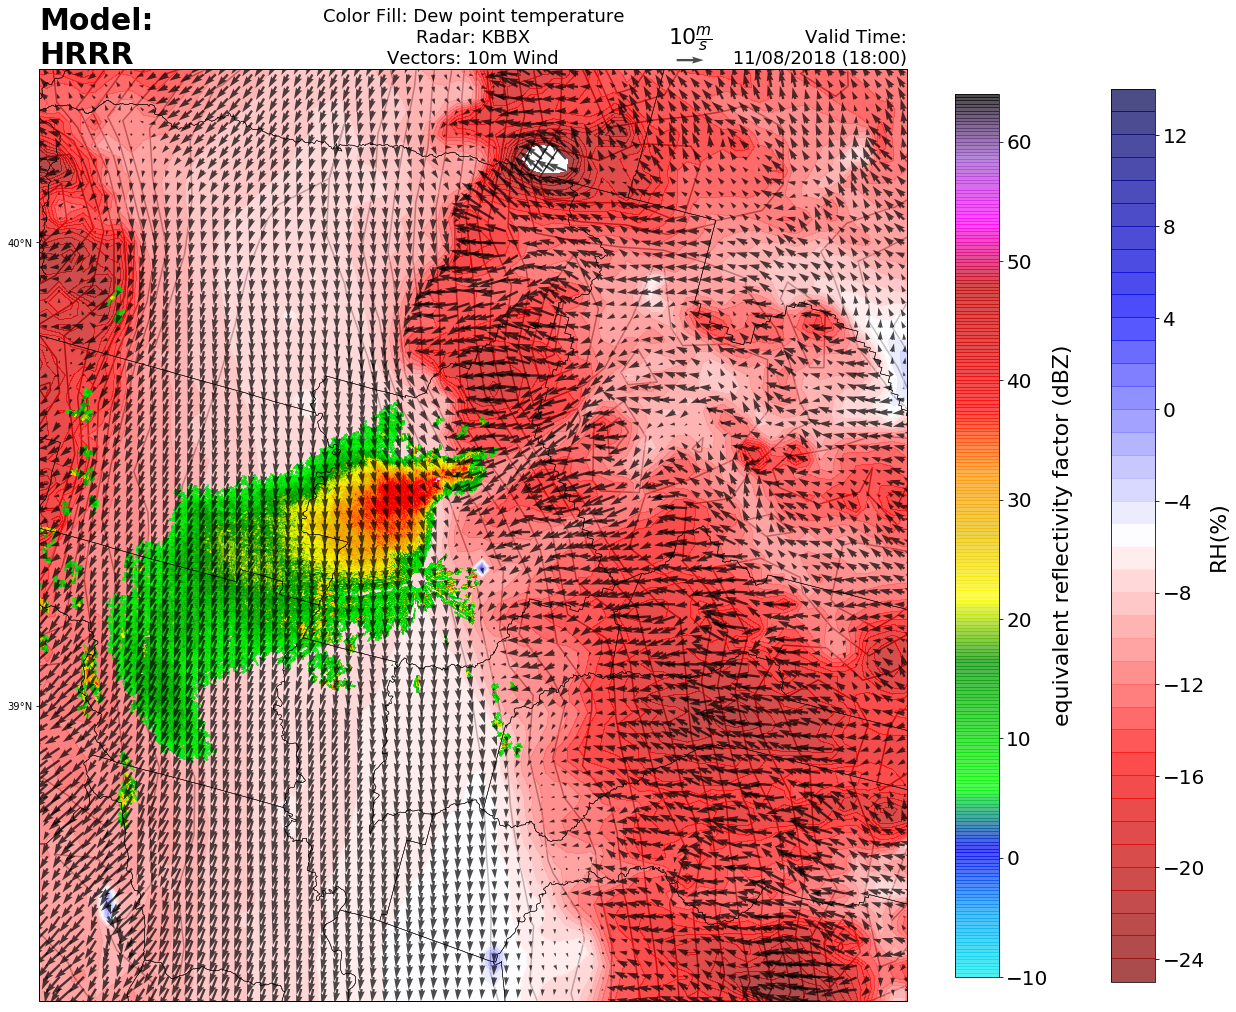

In [36]:
var = DPT_K
DPT_C =DPT_K -273.15

max_lat = 40.5
min_lat = 38.75
min_lon = -122.5
max_lon = -120.5
varlevs = np.arange(-25.,15.,1)
elevation_levs = np.arange(0,6000.,150)
cb_tick_size = 20 # Adjust as appropriate.
font_size = 22
#Creating the figure and adding extra background layers, i.e. elevation, counties, that are not predefined in the plot_background func
fig, ax = plt.subplots(figsize = (20,20),subplot_kw={'projection': crs})
plot_background(ax)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=.5, zorder = 1)
cs1 =ax.contour(elev.longitude,elev.latitude, elev.elevation, elevation_levs, transform = ccrs.PlateCarree(), colors = '#333333', zorder = 1)

#plotting the color fill variable and colorbar
cf = ax.contourf(x,y,DPT_C, varlevs, transform = ccrs.PlateCarree(), cmap = 'seismic_r', alpha = .7, zorder =1, vmin = -25 ) 
cb = fig.colorbar(cf, pad=.1, orientation = 'vertical', fraction=0.04)
cb.ax.tick_params(labelsize=cb_tick_size)
cb.set_label('RH(%)', size = 'x-large', fontsize = font_size )

#plotting the wind vectors, the skip function is usefull for windbarb plots less so for wind vectors
sknum = 1
skip=(slice(None,None,sknum),slice(None,None,sknum))
q = ax.quiver(x[skip].values,y[skip].values, uwind_10m[skip].values, vwind_10m[skip].values,  units='inches',  scale=40,\
              transform= ccrs.PlateCarree(), color = 'k',alpha = .7, zorder = 10)
ax.quiverkey(q, 0.75, 1.01, 15, r'$10 \frac{m}{s}$',coordinates ='axes', fontproperties={'size': font_size})

#reading the radar object in for plotting and creating a specified colorbar
display = pyart.graph.RadarMapDisplayCartopy(radar)    
display.plot_ppi_map('reflectivity', 0, #The "0" is the lowest PPI scan, increasing this number increases the scanning elevation
             vmin=-10, vmax=64, colorbar_flag = False, fig = fig, ax=ax,alpha = .7, gatefilter = gf)
display.plot_colorbar(label_size = font_size ,ticklabel_size = cb_tick_size,  ax =ax)


plt.title('Model:\nHRRR', loc='left', fontweight='bold', fontsize = 30)
plt.title('Color Fill: %s\nRadar: KBBX\nVectors: 10m Wind'%(var.attrs['long_name']), loc='center', fontsize = 18)
plt.title('Valid Time:\n %s' % (var.attrs['initial_time']), loc='right', fontsize = 18)

plt.savefig('HRRR_%s_%s%s_%sz.png'% (var.attrs['long_name'],var.attrs['initial_time'][0:2],var.attrs['initial_time'][3:5],var.attrs['initial_time'][12:14]),dpi = 800, bbox_inches = 'tight')

In [35]:
pyart.__file__

'/export/home/mbrewer/anaconda3/envs/radar/lib/python3.6/site-packages/pyart/__init__.py'